## Sujet 2 : Deep Learning 
### Réalisé par Sayouti Souleymane Nouréini



In [1]:
import time
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import sklearn
import sklearn.datasets
import sklearn.linear_model
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## Lecture de la trainning data de titanic 

In [2]:
cwd = os.getcwd()


In [3]:
print(cwd)

C:\Users\sayouti\Documents\Titanic


In [4]:
train = pd.read_csv('datasets/train.csv')

### Préparation des données

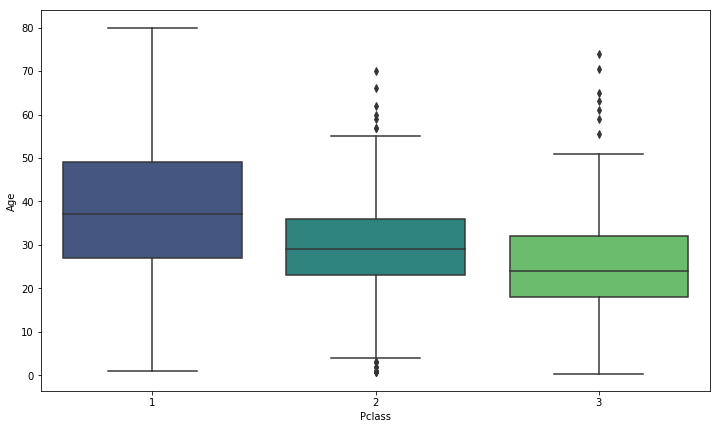

In [5]:
### inputation de l'âge des passagers en se basant sur leur classe. 
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='viridis')

### Comme on peut le voir sur la figure ci dessus, les passagers les plus âgés ont tendance à être dans la classe 1, et les passagers plus jeuens dans la classe 3. Nous pourrons imputer les ages manquants en utilisant l'âge moyen de la classe à laquelle appartient le passager. 


In [6]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

In [7]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)
train.drop('Cabin',axis=1,inplace=True)
train.dropna(inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


###### Extraction des features des noms des passagers, ces features peuvent être le statut matrimonial de la personne, son activité, son rang social, le "titre" ect.....

In [8]:
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'

In [9]:
### La liste de tous les titres trouvés dans la base de données  
titles = sorted(set([x for x in train.Name.map(lambda x: get_title(x))]))
print('les différents titres trouvés dans la base de données:')
print(len(titles), ':', titles)
print()

les différents titres trouvés dans la base de données:
17 : ['Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess']



In [10]:
## Haronisation des titres pour avoir, Mr', 'Master', 'Miss' or 'Mrs'
def replace_titles(x):
    title = x['Title']
    if title in ['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [11]:
### Création d'une nouvelle collonne qui comporte ces titres là; 
train['Title'] = train['Name'].map(lambda x: get_title(x))
train['Title'] = train.apply(replace_titles, axis=1)
### On peut éliminer la colonne des noms qui ne nous ai pas d'une grande utilité 
train.drop('Name', axis=1, inplace=True)

#### Conversion des variables qualitatives en variables dummy avant d'entrainner notre réseau de neuronnes. 



In [12]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)
title = pd.get_dummies(train['Title'],drop_first=True)

In [13]:
train.drop(['Sex','Embarked','Ticket', 'PassengerId', 'Title'],axis=1,inplace=True)
train = pd.concat([train,sex,embark,title],axis=1)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Miss,Mr,Mrs
0,0,3,22.0,1,0,7.2500,1,0,1,0,1,0
1,1,1,38.0,1,0,71.2833,0,0,0,0,0,1
2,1,3,26.0,0,0,7.9250,0,0,1,1,0,0
3,1,1,35.0,1,0,53.1000,0,0,1,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1,0,1,0


### Mise à l'échelle de l'âge et du tarif permet au gradient descendant de l'algorithme du réseau de neurones de converger plus rapidement. 

In [14]:
from sklearn.preprocessing import StandardScaler
age = train['Age'].values.reshape(889,1)
scaler = StandardScaler()
scaler.fit(age)
scaled_age = scaler.transform(age)
train['Age'] = scaled_age

fare = train['Fare'].values.reshape(889,1)
scaler = StandardScaler()
scaler.fit(fare)
scaled_fare = scaler.transform(fare)
train['Fare'] = scaled_fare
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Miss,Mr,Mrs
0,0,3,-0.531670,1,0,-0.500240,1,0,1,0,1,0
1,1,1,0.680232,1,0,0.788947,0,0,0,0,0,1
2,1,3,-0.228695,0,0,-0.486650,0,0,1,1,0,0
3,1,1,0.453001,1,0,0.422861,0,0,1,0,0,1
4,0,3,0.453001,0,0,-0.484133,1,0,1,0,1,0


## Comme nos données sont prêtes nous pourrons appliquer notre réseau de neurones.
### dnn_app_utils_v2 import  est un  package contient toutes les fonctions dont on aura besoin pour créer notre réseau de neuronnes
### Meme si Andrew Ng l'a développé pour classifier les photos, nous l'avons adapté pour la prédiction ici, les functions utilisées sont les mêmes que nn-from scratch


In [15]:
#### Nouvel importation des packages, ces packages se basent sur un cour de Andrew Ng sur le Deep Neural Network pour la classification des images
%matplotlib inline
from dnn_app_utils_v2 import * 
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

C:\Users\sayouti\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [16]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate=learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [17]:
from sklearn.model_selection import train_test_split
X = train.drop('Survived', axis=1)
y = train['Survived']
### Création des données d'apprentissage et des données de test 
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
### Transposition des données
X_tr_T = X_tr.T
X_te_T = X_te.T
y_tr_T = y_tr.T.values.reshape(1,y_tr.shape[0])
y_te_T = y_te.T.values.reshape(1,y_te.shape[0])
X_tr_T.shape

(11, 711)

### Etant donné que nous avons 11 dimensions, la première couche de notre réseau aura 11 dimension. Nous allons utilisé pour un premier essai 3 couches. Une couche (11 dimensions) pour les inputs, une couche cachée avec 25 dimensions et une couche pour l'output avec une seule dimension

In [18]:
## Constant 
layers_dims = [11,25,25,25,25,25,1] #  7-layer model

# Apprentissage du modèle avec les données train de titanic 

In [ ]:
parameters = L_layer_model(X_tr_T, y_tr_T, layers_dims, num_iterations = 2500, print_cost = True)

In [20]:
# Accuracy on the training set. Does the neural network make a good job on its own data?
pred_train = predict(X_tr_T, y_tr_T, parameters)

Accuracy: 0.8340365682137834


In [21]:
# Accuracy on the held out test set.
pred_test = predict(X_te_T, y_te_T, parameters)

Accuracy: 0.8370786516853933


## Création de la soumission Kaggle 

In [22]:
test = pd.read_csv('datasets/test.csv')

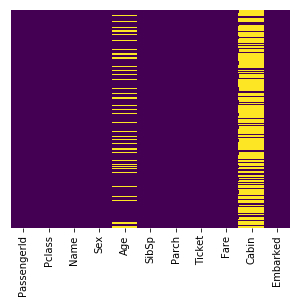

In [23]:
### Vérification des valeurs manquantes 
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [24]:
#### Préparation des données et remplissage des valeurs manquantes de l'âge comme nous l'avons déjà fait 
test['Age'] = test[['Age','Pclass']].apply(impute_age,axis=1)
test.drop('Cabin',axis=1,inplace=True)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S


In [25]:
### lA Liste de tous les "titres" que porte les passagers 
titles = sorted(set([x for x in test.Name.map(lambda x: get_title(x))]))
print('Différents titres trouvés dans la base de données:')
print(len(titles), ':', titles)
print()

Différents titres trouvés dans la base de données:
9 : ['Col', 'Dona', 'Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Ms', 'Rev']



In [26]:
### Création d'une colonne pour les titres 
test['Title'] = test['Name'].map(lambda x: get_title(x))
#### Harmonisation des titres 
test['Title'] = test.apply(replace_titles, axis=1)
test.drop('Name', axis=1, inplace=True)
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,892,3,male,34.5,0,0,330911,7.8292,Q,Mr
1,893,3,female,47.0,1,0,363272,7.0000,S,Mrs
2,894,2,male,62.0,0,0,240276,9.6875,Q,Mr
3,895,3,male,27.0,0,0,315154,8.6625,S,Mr
4,896,3,female,22.0,1,1,3101298,12.2875,S,Mrs


In [27]:
#### Coversion des variables qualitatives 
sex = pd.get_dummies(test['Sex'],drop_first=True)
embark = pd.get_dummies(test['Embarked'],drop_first=True)
title = pd.get_dummies(test['Title'],drop_first=True)


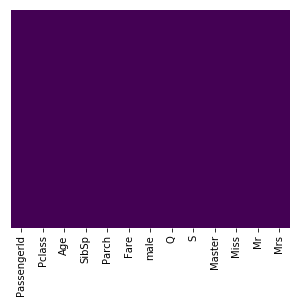

In [28]:
#### On vérifie que tout es ok et on rend encore plus propre les données 
test.drop(['Sex','Embarked','Ticket', 'Title'],axis=1,inplace=True)
test = pd.concat([test,sex,embark,title],axis=1)
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [29]:
### Cependant, pour la variable fare, il manque une valeur, que nous allons remplacé
test.loc[152,'Fare'] = 7

In [30]:
### Mise à l'échelle des variables age et frais, en utlisant la même méthode que celle utilisée pour les données train 
from sklearn.preprocessing import StandardScaler
age = test['Age'].values.reshape(418,1)
scaler = StandardScaler()
scaler.fit(age)
scaled_age = scaler.transform(age)
test['Age'] = scaled_age

fare = test['Fare'].values.reshape(418,1)
scaler = StandardScaler()
scaler.fit(fare)
scaled_fare = scaler.transform(fare)
test['Fare'] = scaled_fare

### Appliquons le réseau de neurones maintenant 

In [31]:
X = test.drop(['PassengerId','Master'], axis=1)

In [32]:
### on transpose X
X_tr_T = X.T
X_tr_T.shape

(11, 418)

# Prédiction des survivants en utilisant la propagation forward 


In [33]:
probas, caches = L_model_forward(X_tr_T, parameters)

### Un seuil de 0.5 est utilisé pour transformer les probabilités en 0 ou 1

In [34]:
p = np.zeros((1,X_tr_T.shape[1]))
for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

In [35]:
p.shape

(1, 418)

## Sauvegarde des prédictions 


In [36]:
pIds = pd.DataFrame(data=test['PassengerId'], columns=['PassengerId'], dtype=int)

# On Transpose la data frame des predictions en un vecteur colonne
preds = pd.DataFrame(data=p.T, columns=['Survived'], dtype=int)

final_prediction = pd.concat([pIds, preds], axis=1)

In [37]:
final_prediction.to_csv('titanic_survival_SSN_AMSE_predictions.csv', index=False)